Graph saved as efficient_frontier.png

--- OPTIMIZATION RESULTS ---
Max Sharpe Ratio Portfolio Return: 16.37%
Minimum Volatility Portfolio Risk: 12.80%

CSV files with optimal weights generated successfully.


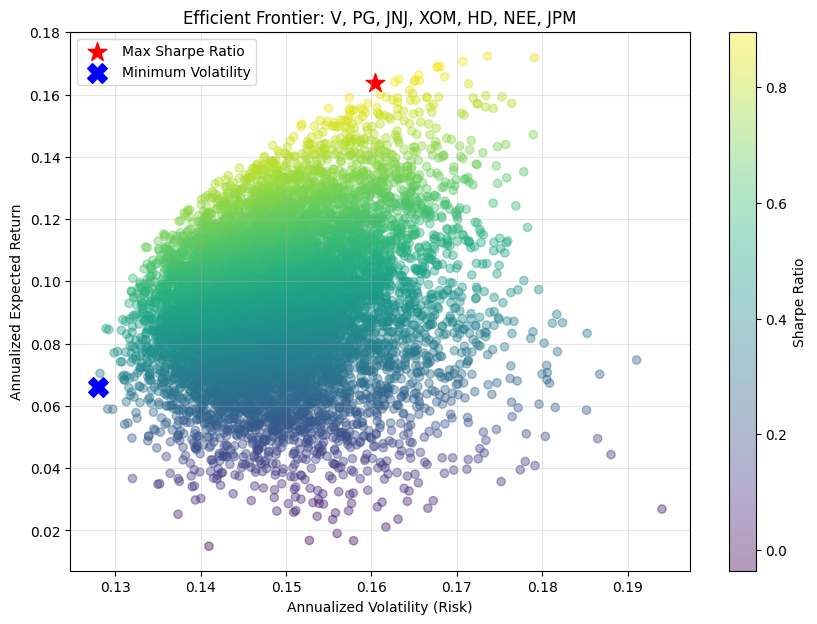

In [1]:
# Efficient Frontier / Markowitz Portfolio Optimization
# ----------------------------------------------------
# Analysis of 7 Diverse Blue-Chip Stocks
# Outputs: efficient_frontier.png, weights_max_sharpe.csv, weights_min_vol.csv, params.json

import json
import time
from typing import List, Tuple

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# 1. GLOBAL SETTINGS
SEED = 42
np.random.seed(SEED)

# Analysis Period: 3 years
START = "2022-01-01"
END   = "2025-01-01"
RF_RATE = 0.02          # Assumed 2% annual risk-free rate
TRADING_DAYS = 252
N_PORTFOLIOS = 10_000

# NEW TICKER SELECTION (7 Diverse Sectors)
# Finance, Consumer Staples, Healthcare, Energy, Retail, Utilities, Banking
TICKERS = ["V", "PG", "JNJ", "XOM", "HD", "NEE", "JPM"]

# 2. DATA ACQUISITION & PREPARATION
def fetch_stock_data(tickers: List[str], start: str, end: str) -> pd.DataFrame:
    print(f"Downloading historical data for: {tickers}")
    raw_data = yf.download(tickers, start=start, end=end, auto_adjust=True, progress=False)['Close']

    # Cleaning: Handle missing values to align timelines
    clean_data = raw_data.ffill().dropna()

    if clean_data.empty:
        raise ValueError("No data found for the selected dates.")
    return clean_data

def calculate_annual_stats(prices: pd.DataFrame) -> Tuple[pd.Series, pd.DataFrame]:
    # Convert prices to daily returns
    daily_returns = prices.pct_change().dropna()

    # Annualize mean returns and covariance matrix
    mean_returns = daily_returns.mean() * TRADING_DAYS
    covariance_matrix = daily_returns.cov() * TRADING_DAYS

    return mean_returns, covariance_matrix

# 3. MONTE CARLO SIMULATION
def run_portfolio_simulation(mean_returns: pd.Series,
                             cov_matrix: pd.DataFrame,
                             n_simulations: int = N_PORTFOLIOS,
                             rf: float = RF_RATE) -> pd.DataFrame:
    num_assets = len(mean_returns)

    results = np.zeros((3 + num_assets, n_simulations))

    for i in range(n_simulations):
        # Generate random weights and normalize to 100%
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)

        # Calculate Portfolio Return and Volatility
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

        # Calculate Sharpe Ratio
        sharpe_ratio = (portfolio_return - rf) / portfolio_volatility

        results[0,i] = portfolio_return
        results[1,i] = portfolio_volatility
        results[2,i] = sharpe_ratio

        # Store weights
        for j in range(len(weights)):
            results[j+3,i] = weights[j]

    # Create detailed DataFrame
    columns = ['Return', 'Volatility', 'Sharpe_Ratio'] + [f'weight_{t}' for t in mean_returns.index]
    return pd.DataFrame(results.T, columns=columns)

# 4. VISUALIZATION
def plot_efficient_frontier(sim_data: pd.DataFrame, max_sharpe: pd.Series, min_vol: pd.Series):
    plt.figure(figsize=(10, 7))

    # Plot all simulated portfolios colored by Sharpe Ratio
    scatter = plt.scatter(sim_data['Volatility'], sim_data['Return'],
                          c=sim_data['Sharpe_Ratio'], cmap='viridis', alpha=0.4)
    plt.colorbar(scatter, label='Sharpe Ratio')

    # Mark the optimal portfolios
    plt.scatter(max_sharpe['Volatility'], max_sharpe['Return'], color='red', marker='*', s=200, label='Max Sharpe Ratio')
    plt.scatter(min_vol['Volatility'], min_vol['Return'], color='blue', marker='X', s=200, label='Minimum Volatility')

    plt.title(f"Efficient Frontier: {', '.join(TICKERS)}")
    plt.xlabel("Annualized Volatility (Risk)")
    plt.ylabel("Annualized Expected Return")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig("efficient_frontier.png")
    print("Graph saved as efficient_frontier.png")

# 5. MAIN EXECUTION
def main():
    # Step 1: Data
    prices = fetch_stock_data(TICKERS, START, END)
    mean_returns, cov_matrix = calculate_annual_stats(prices)

    # Step 2: Simulation
    sim_results = run_portfolio_simulation(mean_returns, cov_matrix)

    # Step 3: Find Optimal Points
    max_sharpe_idx = sim_results['Sharpe_Ratio'].idxmax()
    min_vol_idx = sim_results['Volatility'].idxmin()

    max_sharpe_portfolio = sim_results.iloc[max_sharpe_idx]
    min_vol_portfolio = sim_results.iloc[min_vol_idx]

    # Step 4: Output & Artifacts
    plot_efficient_frontier(sim_results, max_sharpe_portfolio, min_vol_portfolio)

    # Export Weights to CSV
    weight_cols = [c for c in sim_results.columns if 'weight_' in c]
    max_sharpe_portfolio[weight_cols].to_csv("weights_max_sharpe.csv")
    min_vol_portfolio[weight_cols].to_csv("weights_min_vol.csv")

    print("\n--- OPTIMIZATION RESULTS ---")
    print(f"Max Sharpe Ratio Portfolio Return: {max_sharpe_portfolio['Return']:.2%}")
    print(f"Minimum Volatility Portfolio Risk: {min_vol_portfolio['Volatility']:.2%}")
    print("\nCSV files with optimal weights generated successfully.")

if __name__ == "__main__":
    main()